In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
input_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomPerspective(0.2),
    transforms.AutoAugment(),
    # transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((400, 400)),
    # transforms.RandomAdjustSharpness(0.3),
    transforms.Resize((256, 256)),
    transforms.RandomGrayscale(),

    transforms.ToTensor(),
    # transforms.RandomErasing(0.2),
    transforms.Normalize(0.5, 0.5)
])

output_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

training_data = datasets.Flowers102(root="data", split="train", download=False, transform=input_transform)
validation_data = datasets.Flowers102(root="data", split="val", download=False, transform=output_transform)
test_data = datasets.Flowers102(root="data", split="test", download=False, transform=output_transform)

torch.Size([3, 256, 256])

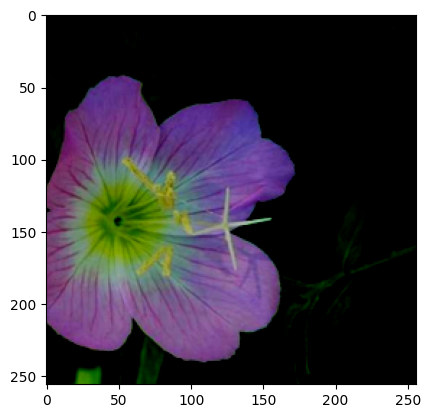

In [4]:
plt.imshow(test_data[1][0].permute(1, 2, 0))
test_data[1][0].shape

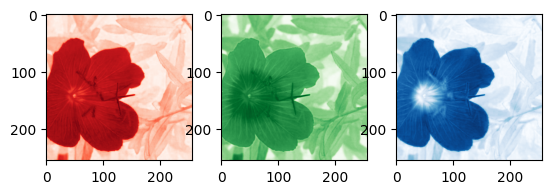

In [5]:
f, ax = plt.subplots(1, 3)
ax[0].imshow(test_data[1][0][0], cmap="Reds")
ax[1].imshow(test_data[1][0][1], cmap="Greens")
ax[2].imshow(test_data[1][0][2], cmap="Blues")

In [6]:
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()

class FlowersModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.LeakyReLU()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.dropout2d = nn.Dropout2d(0.2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64 * 32 * 32, 256)
        self.batch_norm4 = nn.BatchNorm1d(256)
        self.final = nn.Linear(256, 102)
        self.softmax = nn.LogSoftmax(dim=1)
        self.output = nn.Sequential(
            self.conv1,
            self.relu,
            self.batch_norm1,
            self.pool2,
            self.conv2,
            self.relu,
            self.batch_norm2,
            self.dropout2d,
            self.pool2,
            self.conv3,
            self.relu,
            self.batch_norm3,
            self.pool2,
            self.flatten,
            self.dropout,
            self.linear,
            self.relu,
            self.batch_norm4,
            self.dropout,
            self.final,
            self.softmax
        )

    def forward(self, x):
        return self.output(x)

    def get_first_conv_output(self, x):
        return self.relu(self.conv1(x))

    def get_second_conv_output(self, x):
        x = self.relu(self.conv1(x))
        return self.relu(self.conv2(self.pool1(x)))

    def get_third_conv_output(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(self.pool1(x)))
        return self.relu(self.conv3(self.pool2(x)))

model = FlowersModel().to(device)
model

FlowersModel(
  (relu): LeakyReLU(negative_slope=0.01)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2d): Dropout2d(p=0.2, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=65536, out_features=256, bias=True)
  (batch_norm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final): Linear(in_features=256, ou

In [21]:
learning_rate = 0.001
loss_fn = nn.NLLLoss()
optimiser = torch.optim.AdamW(model.parameters(), learning_rate)
# scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.9)
# scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[30,80], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.8)

In [22]:
def train(dataloader: DataLoader, training_model: nn.Module, optim: torch.optim.Optimizer):
    size = len(dataloader.dataset)
    training_model.train()
    for batch_no, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred = training_model(X)
#         actual = nn.functional.one_hot(y, 102)

        loss = loss_fn(pred, y)
        loss.backward()
        optim.step()

        if batch_no % 4 == 0:
            loss, current = loss.item(), (batch_no + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader:DataLoader, eval_model: nn.Module, losses: list, accuracy: list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = eval_model(X)
#             actual = nn.functional.one_hot(y, 102)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    total_loss /= num_batches
    correct /= size

    losses.append(total_loss)
    accuracy.append(100 * correct)

    print(f"Accuracy: {(100 * correct):>0.1f}%, Avg loss: {total_loss:>8f} \n")
    return total_loss


In [31]:
print(device)
epochs = 120
# val_losses = []
# val_accuracy = []
# train_losses = []
# train_accuracy = []
# epoch_list = []

for t in range(epochs):
    print(f"Epoch {t + 241}\n-------------------------------")
    train(train_dataloader, model, optimiser)
    epoch_list.append(t+241)
    print("Validation Error:")
    loss1 = test(val_dataloader, model, val_losses, val_accuracy)
    print("Training Error:")
    loss2 = test(train_dataloader, model, train_losses, train_accuracy)
    scheduler.step()

    # epoch_list.append(t)

print("Done!")


cuda
Epoch 241
-------------------------------
loss: 2.340311 [  128/ 1020]
loss: 2.257232 [  640/ 1020]
Validation Error:
Accuracy: 49.9%, Avg loss: 2.044534 

Training Error:
Accuracy: 52.0%, Avg loss: 1.958070 

Epoch 242
-------------------------------
loss: 2.639326 [  128/ 1020]
loss: 2.342116 [  640/ 1020]
Validation Error:
Accuracy: 49.9%, Avg loss: 2.064427 

Training Error:
Accuracy: 51.8%, Avg loss: 2.039316 

Epoch 243
-------------------------------
loss: 2.229205 [  128/ 1020]
loss: 2.257051 [  640/ 1020]
Validation Error:
Accuracy: 50.2%, Avg loss: 2.041220 

Training Error:
Accuracy: 50.2%, Avg loss: 2.029491 

Epoch 244
-------------------------------
loss: 2.468345 [  128/ 1020]
loss: 2.511885 [  640/ 1020]
Validation Error:
Accuracy: 49.1%, Avg loss: 2.036911 

Training Error:
Accuracy: 54.5%, Avg loss: 1.926754 

Epoch 245
-------------------------------
loss: 2.298992 [  128/ 1020]
loss: 2.640109 [  640/ 1020]
Validation Error:
Accuracy: 48.4%, Avg loss: 2.034419 


In [36]:
print("Testing error:")
test(test_dataloader, model, [], [])

Testing error:
Accuracy: 50.3%, Avg loss: 2.066017 



2.0660165262465573

(0.0, 5.0)

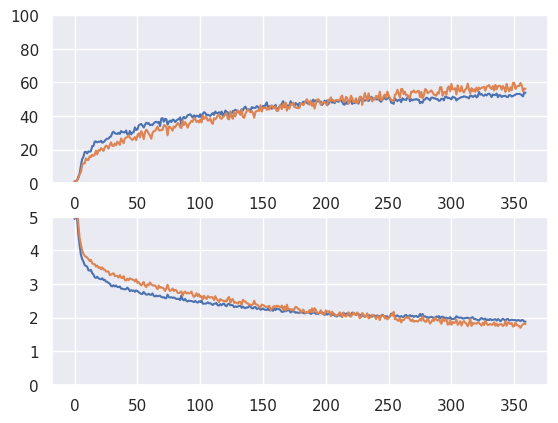

In [34]:
sns.set()
f, ax = plt.subplots(2, 1)
# ax[0].plot(epoch_list, test_accuracy)
ax[0].plot(val_accuracy)
ax[0].plot(train_accuracy)
ax[0].set_ylim(0, 100)
# ax[1].plot(epoch_list, test_losses)
ax[1].plot(val_losses)
ax[1].plot(train_losses)
ax[1].set_ylim(0, 5)

In [35]:
torch.save(model, "model-inprogress-5.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [38]:
scheduler.gamma

0.8